In [2]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm


# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [3]:
dataset_dir = "/data_dir"
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)

stock_list
stock_price
stock_fin
stock_labels


In [5]:
# for k in inputs.keys():
#     print(k)
#     print(dfs[k].info())
#     print(dfs[k].head(1).T)

# 2.4.1. 財務諸表

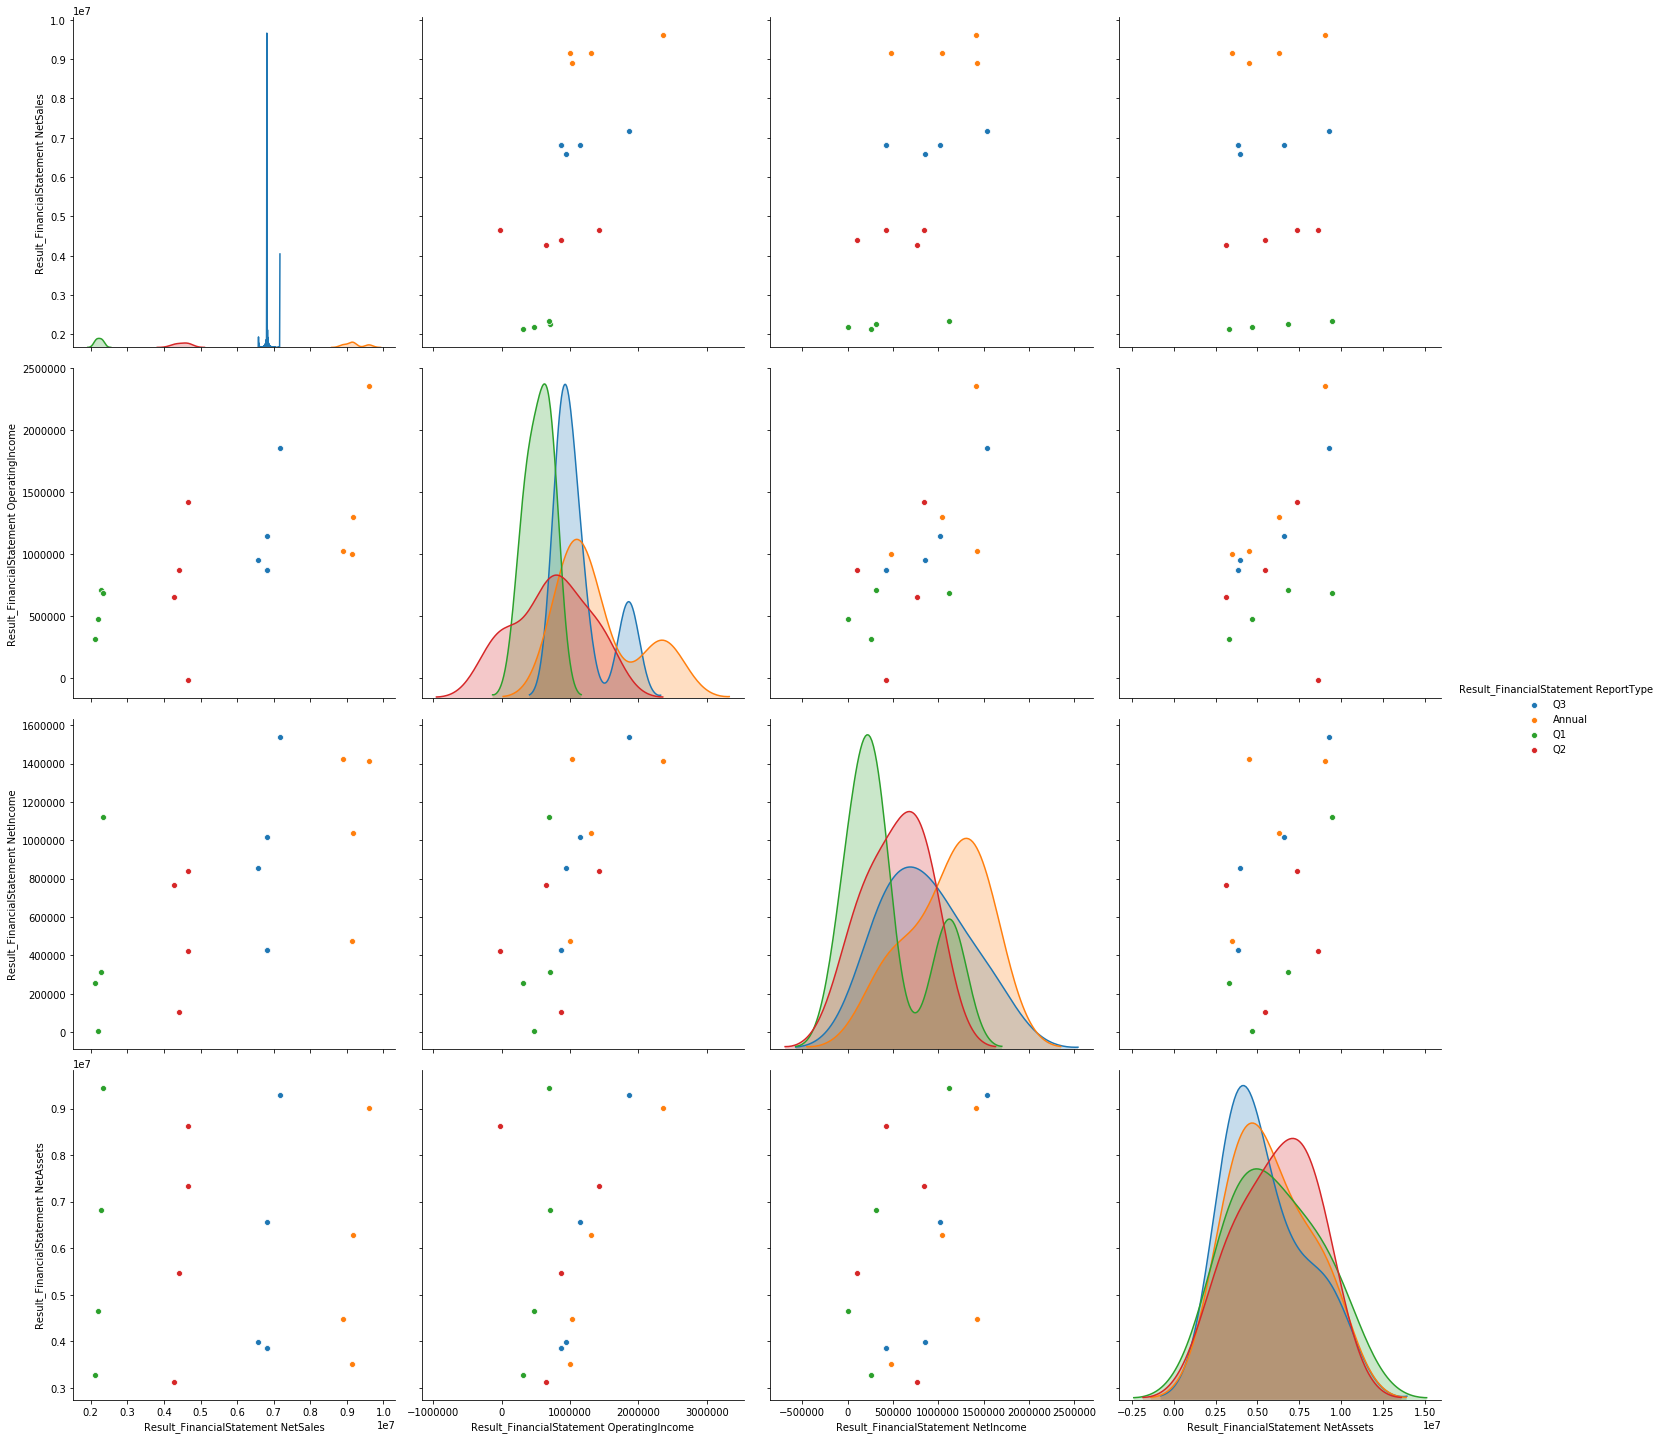

In [6]:
# stock_finの読み込み
fin = dfs["stock_fin"].copy()

# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["Local Code"] == code].copy()

# 日付列をpd.Timestamp型に変換してindexに設定
fin_data["datetime"] = pd.to_datetime(fin_data["base_date"])
fin_data.set_index("datetime", inplace=True)
# 2019年までの値を表示
fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# プロット
sns.pairplot(fin_data[columns], hue="Result_FinancialStatement ReportType", height=5)

# 複数銘柄のファンダメンタル情報の比較

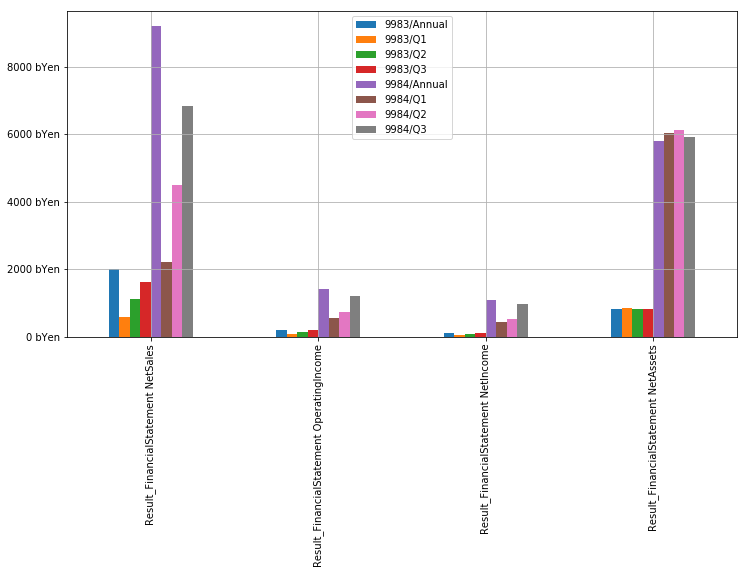

In [7]:
# stock_finの読み込み
fin = dfs["stock_fin"].copy()

# 銘柄コード9984と9983を比較する
codes = [9984, 9983]

multi_df = dict()

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = fin[fin["Local Code"] == code].copy()
    # 日付列をpd.Timestamp型に変換してindexに設定
    fin_data.loc[:, "datetime"] = pd.to_datetime(fin_data["base_date"])
    fin_data.set_index("datetime", inplace=True)
    # 2019年までの値を表示
    fin_data = fin_data[:"2019"]
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "Local Code",
            "Result_FinancialStatement FiscalYear",
            "Result_FinancialStatement ReportType"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("Result_FinancialStatement ReportType").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

# 2.4.3. 移動平均

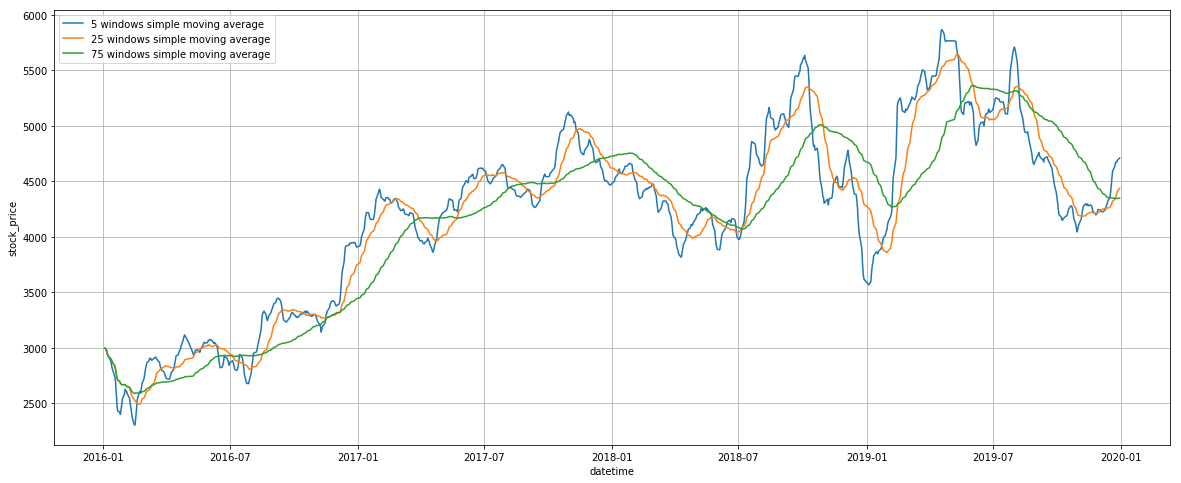

In [9]:
# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

# 2.4.4. 価格変化率

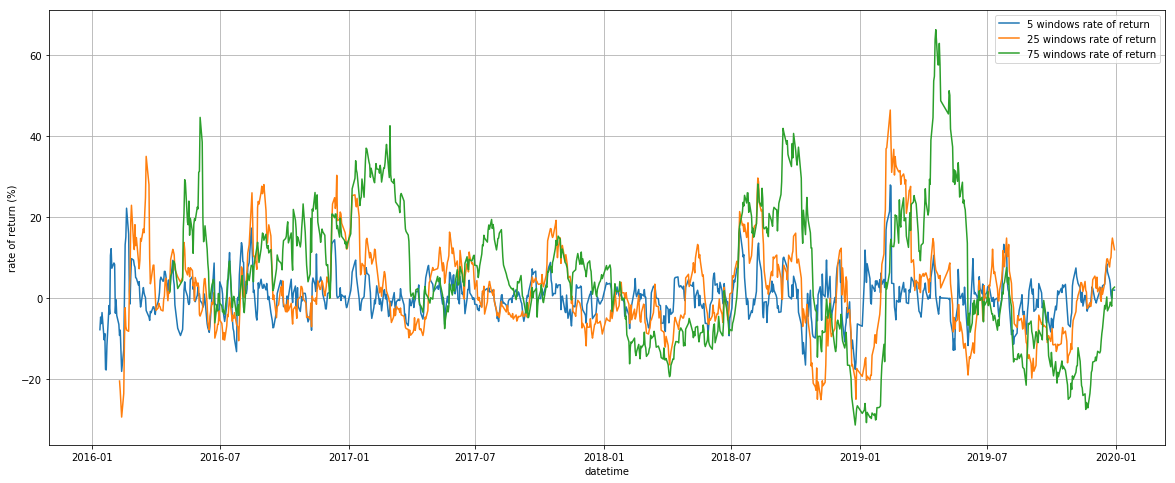

In [10]:
# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

# 2.4.5. ヒストリカル・ボラティリティ

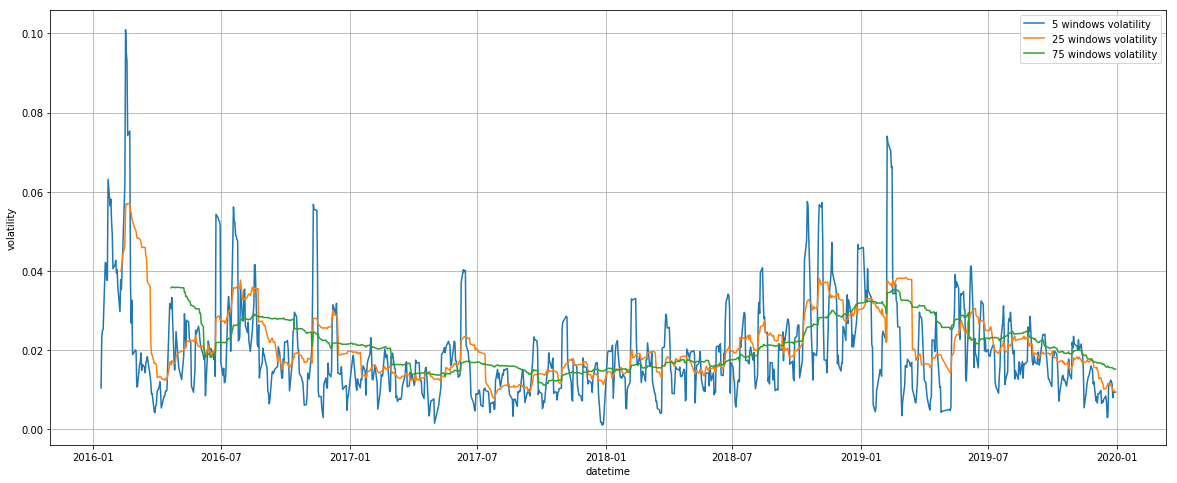

In [11]:
# 5日、25日、75日のヒストリカル・ボラティリティを算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

# すべてのグラフを合わせた結果

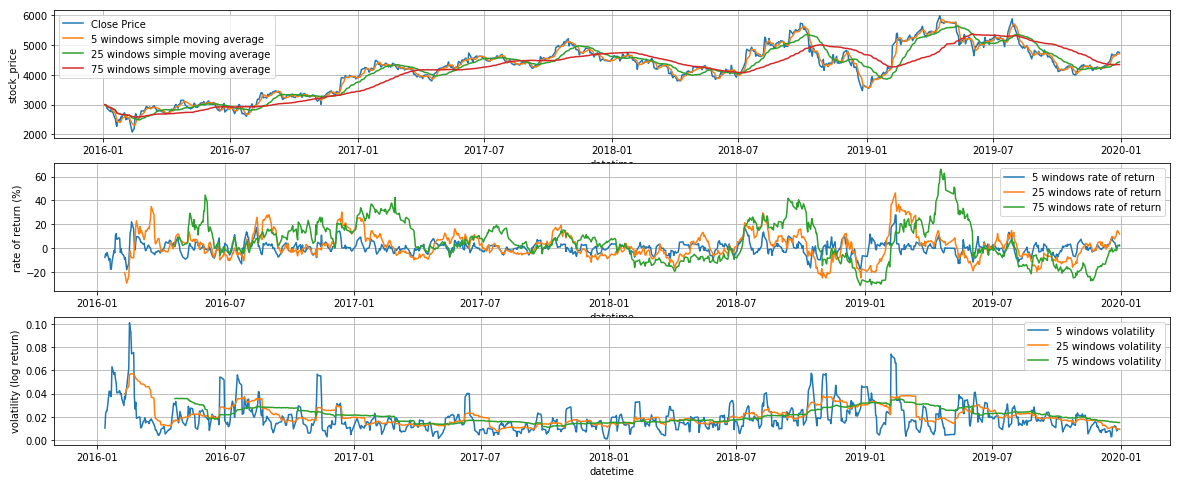

In [12]:
# 5日、25日、75日を対象に値を算出
periods = [5, 25, 75]
ma_cols = []
# 移動平均線
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    ma_cols.append(col)

return_cols = []
# 価格変化率
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    return_cols.append(col)

vol_cols = []
# ヒストリカル・ボラティリティ
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    vol_cols.append(col)

# プロット
fig, ax = plt.subplots(nrows=3 ,figsize=(20, 8))

ax[0].plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label="Close Price")

for col in ma_cols:
    ax[0].plot(price_data[col], label=col)

for col in return_cols:
    ax[1].plot(price_data[col], label=col)

for col in vol_cols:
    ax[2].plot(price_data[col], label=col)

ax[0].set_ylabel("stock_price")
ax[1].set_ylabel("rate of return (%)")
ax[2].set_ylabel("volatility (log return)")
for _ax in ax:
    _ax.set_xlabel("datetime")
    _ax.grid(True)
    _ax.legend()